# Structure from motion

Import everything *except* our sfm library.

In [1]:
# Import symforce for the sole purpose of setting the value
# of epsilon, which must be done first and exactly once.
import symforce
symforce.set_epsilon_to_symbol()

import importlib
from pathlib import Path
import numpy as np
import secrets
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import rerun as rr
from uuid import uuid4

from pupil_apriltags import Detector
import json

Import our sfm library. (Re-evaluate this cell if you make changes to the library.)

In [2]:
import sfm
importlib.reload(sfm)

<module 'sfm' from '/Users/sam/Documents/phd/AE598/Air-to-air-3dv/sfm.py'>

Choose parameter values.

In [3]:
# When reading video frames
frames_to_skip = 30

# When matching (max threshold for ratio test)
matching_threshold = 0.5

# When deciding if triangulated points are invalid
max_reprojection_err = 0.85

# Camera matrix
K = np.array([
    [1223.359872901537, 0.0, 1014.9134915659537],
    [0.0, 1225.3894727126913, 459.47404470286574],
    [0.0, 0.0, 1.0],
])

Create random number generator.

In [4]:
seed = secrets.randbits(32)
print(f'seeding RNG with {seed}')
rng = np.random.default_rng(seed)

seeding RNG with 167794098


Initialize 3D visualizer (should open the rerun application if that isn't already open).

In [5]:
# Create recording with unique ID
rr.init('my_sfm', recording_id=uuid4(), spawn=True)

# Initialize a time sequence
rr.set_time_seconds('stable_time', 0)

# Make view coordinates consistent with camera frames (z forward, x right, y down)
rr.log('/results', rr.ViewCoordinates.RDF, timeless=True)

Found existing process on port 9876. Trying to connect.


Load images from video.

In [6]:
def getmask(img, light, dark):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)

    mask = cv2.inRange(hsv_img, light, dark)
    hsv_result_hsv = cv2.bitwise_and(hsv_img, hsv_img, mask=mask)
    
    hsv_result_brg = cv2.cvtColor(hsv_result_hsv, cv2.COLOR_HSV2BGR)
    hsv_result = cv2.cvtColor(hsv_result_brg, cv2.COLOR_BGR2GRAY)
    
    return mask, hsv_result
    
def crop(img, size):
    img = img[480:1440, 270:810] # crop
    return img


In [10]:
# Specify filename
video_filename = Path('../chaseVideoFive.mp4') # chaseVideoOne
light = (0, 0, 200) # hsv value for light end of airplane range
dark = (145, 60, 255) # hsv value for dark end of airplane range

# Create a video reader
video_src = cv2.VideoCapture(str(video_filename))

# Get frame count and frames per second
frame_count = int(video_src.get(cv2.CAP_PROP_FRAME_COUNT))
frames_per_second = video_src.get(cv2.CAP_PROP_FPS)

# Read frames
views = []
for i_frame in range(0, frame_count, frames_to_skip):
    video_src.set(cv2.CAP_PROP_POS_FRAMES, i_frame)
    success, frame = video_src.read()
    assert(success)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mask, masked = getmask(img, light, dark)
    views.append({
        'frame_id': i_frame,
        'frame': frame,
        'img': img,
        'mask': mask,
        'masked': masked,
        'R_inB_ofA': None,
        'p_inB_ofA': None,
    })
print(f'read {len(views)} images from video')

read 4 images from video


Detection.

In [11]:
# grid tag detection
template_filename = Path(".", 'tag36_11_grid_5x8-template.json')
with open(template_filename, 'r') as f:
    template = json.load(f)
    
tag_detector = Detector(
    families=template['tag_family'],
    nthreads=1,
    quad_decimate=1.0,
    quad_sigma=0.0,
    refine_edges=1,
    decode_sharpening=0.,
    debug=0,
)

def get_tag_with_id(tag_id, template):
    for tag in template['tags']:
        if tag['tag_id'] == tag_id:
            return tag
    raise Exception(f'tag_id {tag_id} not found in template')

In [47]:
# detect tags

# Tag corners must be no less than this number of pixels from the image border
buffer_px = 10

# Iterate over all images in the source directory
for view in views:    
    # Read image as grayscale
    img = view['img']
    
    # Detect tags
    tag_detections = tag_detector.detect(
        img,
        estimate_tag_pose=False, #True,
        camera_params=np.array([K[0,0], K[1,1], K[0,2], K[1,2]]),
        tag_size=0.024,
    )
    
    #print(tag_detections)
    # Get n point correspondences:
    #
    #  p (n x 3) is coordinates of each point in the tag frame
    #  q (n x 2) is coordinates of each point in the image frame
    #
    rejected_tags = []
    tags = []
    p = []
    q = []
    for d in tag_detections:
        #print(d)
        # Reject tags with corners too close to the image boundary
        if ((d.corners[:, 0] < buffer_px).any() or
            (d.corners[:, 0] > (img.shape[1] - 1) - buffer_px).any() or
            (d.corners[:, 1] < buffer_px).any() or
            (d.corners[:, 1] > (img.shape[0] - 1) - buffer_px).any()):
            continue
        
        # Add tag to list of detected tags
        tags.append({
            'tag_id': d.tag_id,
            'corners': d.corners.tolist(),
            'center': d.center,
            #'R': d.pose_R,
            #'p': d.pose_t,
            #'error': d.pose_err,
        })
        
        # Add corners of tag to point correspondences
        p.extend(get_tag_with_id(d.tag_id, template)['corners'])
        q.extend(d.corners.tolist())
        
    #view['tags'] = [
    #{
    #    'tag_id': d.tag_id,
    #    'corners': d.corners.tolist(),
    #    'center': d.center,
    #    'R': d.pose_R,
    #    'p': d.pose_t,
    #    'error': d.pose_err
    #}
    #]
    
    view['tags'] = tags
    
    print(view['tags'])
    
    # Make sure the lengths of p and q are consistent
    assert(len(p) == len(q))
    
    # Count the number of tags and correspondences that were found
    num_tags = len(tags)
    num_points = len(p)
    

[{'tag_id': 5, 'corners': [[813.8986816406251, 140.4673919677734], [840.7091064453124, 137.45135498046875], [831.0408325195312, 125.27124786376956], [804.0432739257814, 127.90727996826169]], 'center': array([822.61420283, 132.7412719 ])}, {'tag_id': 8, 'corners': [[498.1195068359374, 392.7044982910156], [535.5328369140626, 386.6981506347657], [530.7161254882812, 364.24258422851557], [494.4655151367188, 369.37069702148426]], 'center': array([514.94628362, 378.01210704])}, {'tag_id': 9, 'corners': [[731.287109375, 354.2663269042969], [765.9661865234375, 349.9751281738282], [755.9070434570314, 328.7463073730469], [722.0164794921876, 333.147216796875]], 'center': array([743.66477987, 341.4361385 ])}]
[{'tag_id': 3, 'corners': [[182.06893920898438, 384.9169921875], [219.89280700683597, 372.34259033203125], [209.6947784423828, 355.72885131835943], [172.0603485107422, 367.87118530273443]], 'center': array([196.07740831, 370.11631351])}, {'tag_id': 4, 'corners': [[504.1301879882812, 274.862945

In [48]:
print(views[0])

{'frame_id': 0, 'frame': array([[[158, 159, 176],
        [146, 147, 165],
        [123, 124, 141],
        ...,
        [ 96, 109, 126],
        [ 84,  97, 115],
        [ 89, 102, 119]],

       [[186, 187, 204],
        [180, 181, 198],
        [168, 169, 187],
        ...,
        [113, 126, 144],
        [102, 115, 132],
        [107, 119, 137]],

       [[181, 182, 200],
        [187, 188, 205],
        [198, 200, 217],
        ...,
        [ 90, 103, 120],
        [ 79,  91, 109],
        [ 83,  96, 113]],

       ...,

       [[124, 133, 136],
        [124, 133, 136],
        [124, 133, 136],
        ...,
        [ 42,  48,  60],
        [ 32,  38,  49],
        [ 27,  33,  45]],

       [[125, 134, 137],
        [125, 134, 137],
        [125, 134, 137],
        ...,
        [ 86,  91, 103],
        [ 42,  48,  60],
        [ 20,  26,  38]],

       [[125, 134, 137],
        [125, 134, 137],
        [125, 134, 137],
        ...,
        [108, 113, 125],
        [ 47,  53,  65],

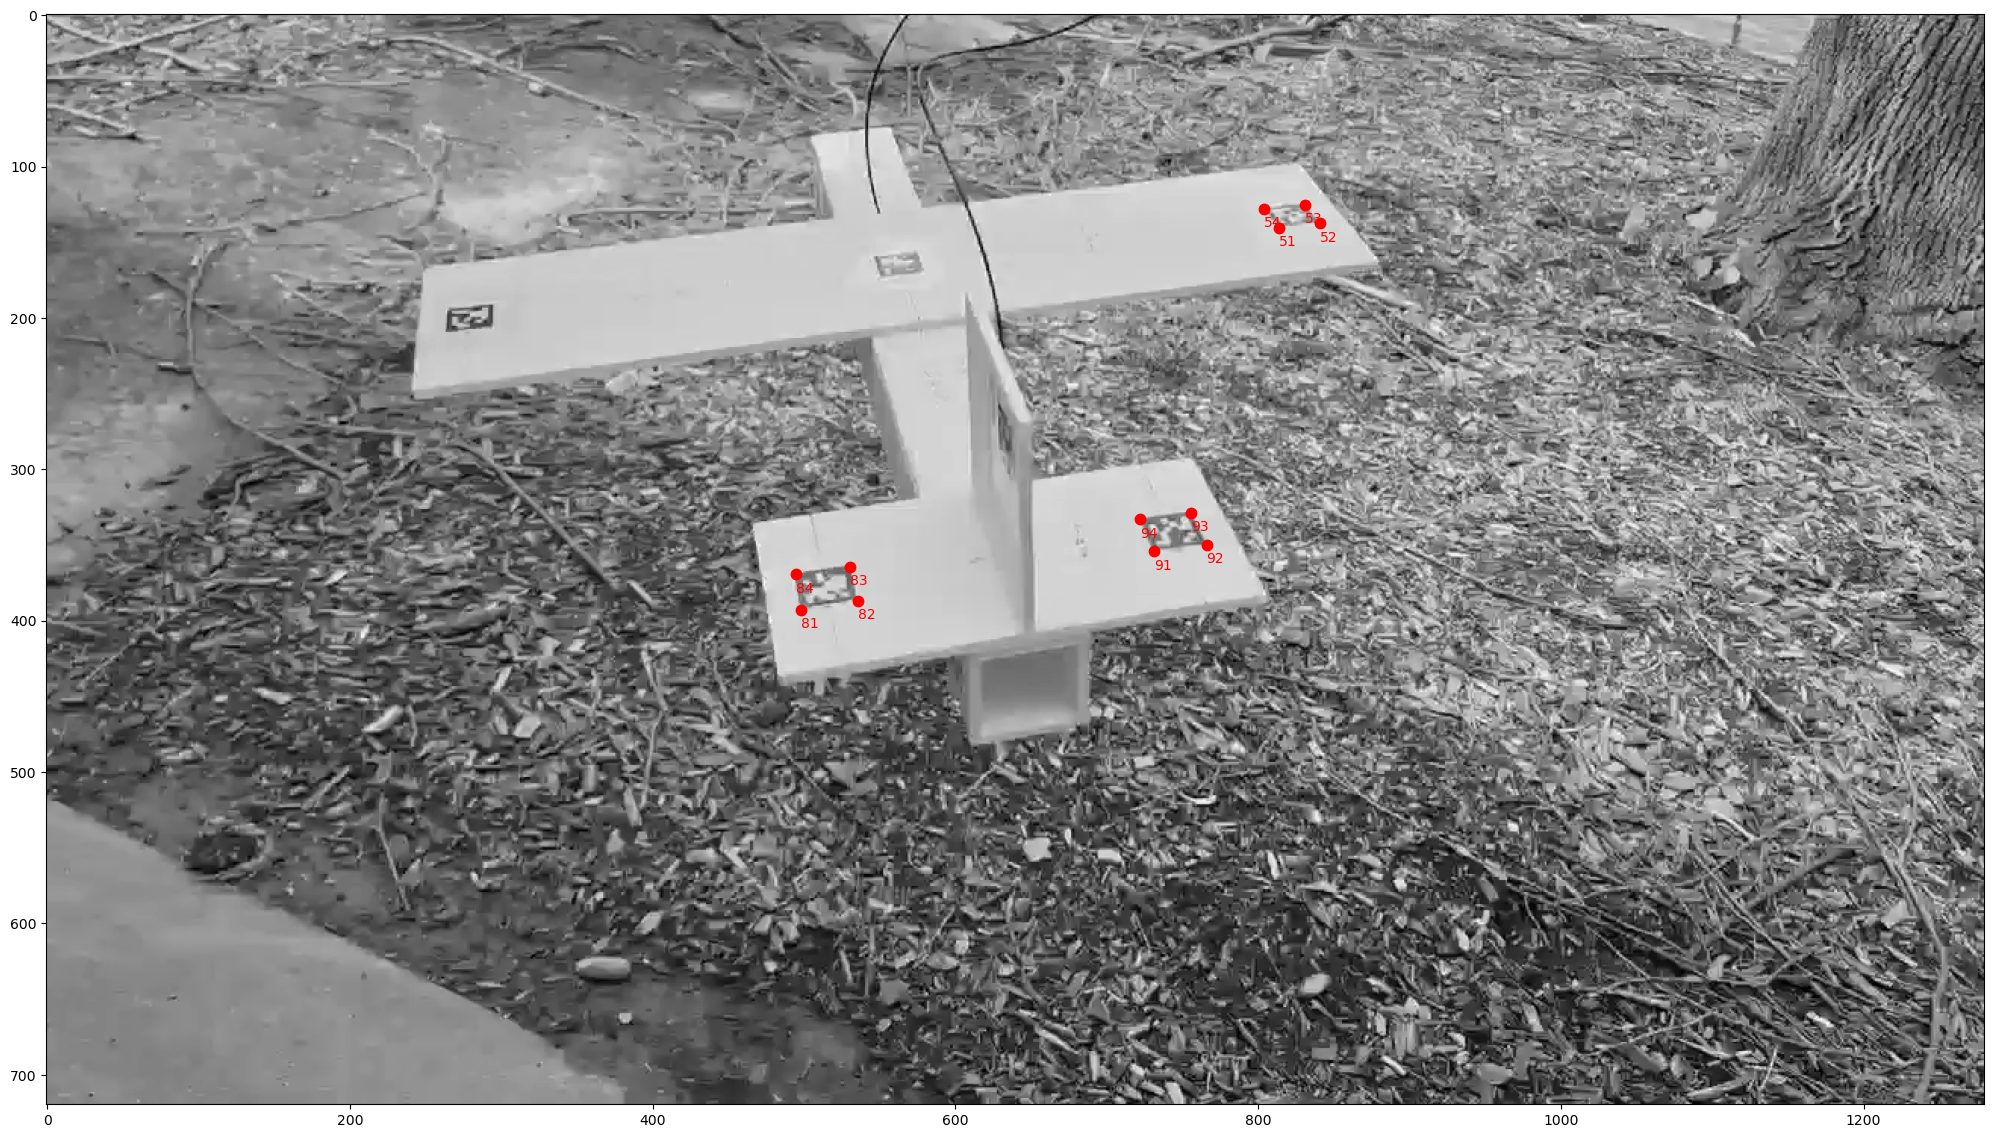

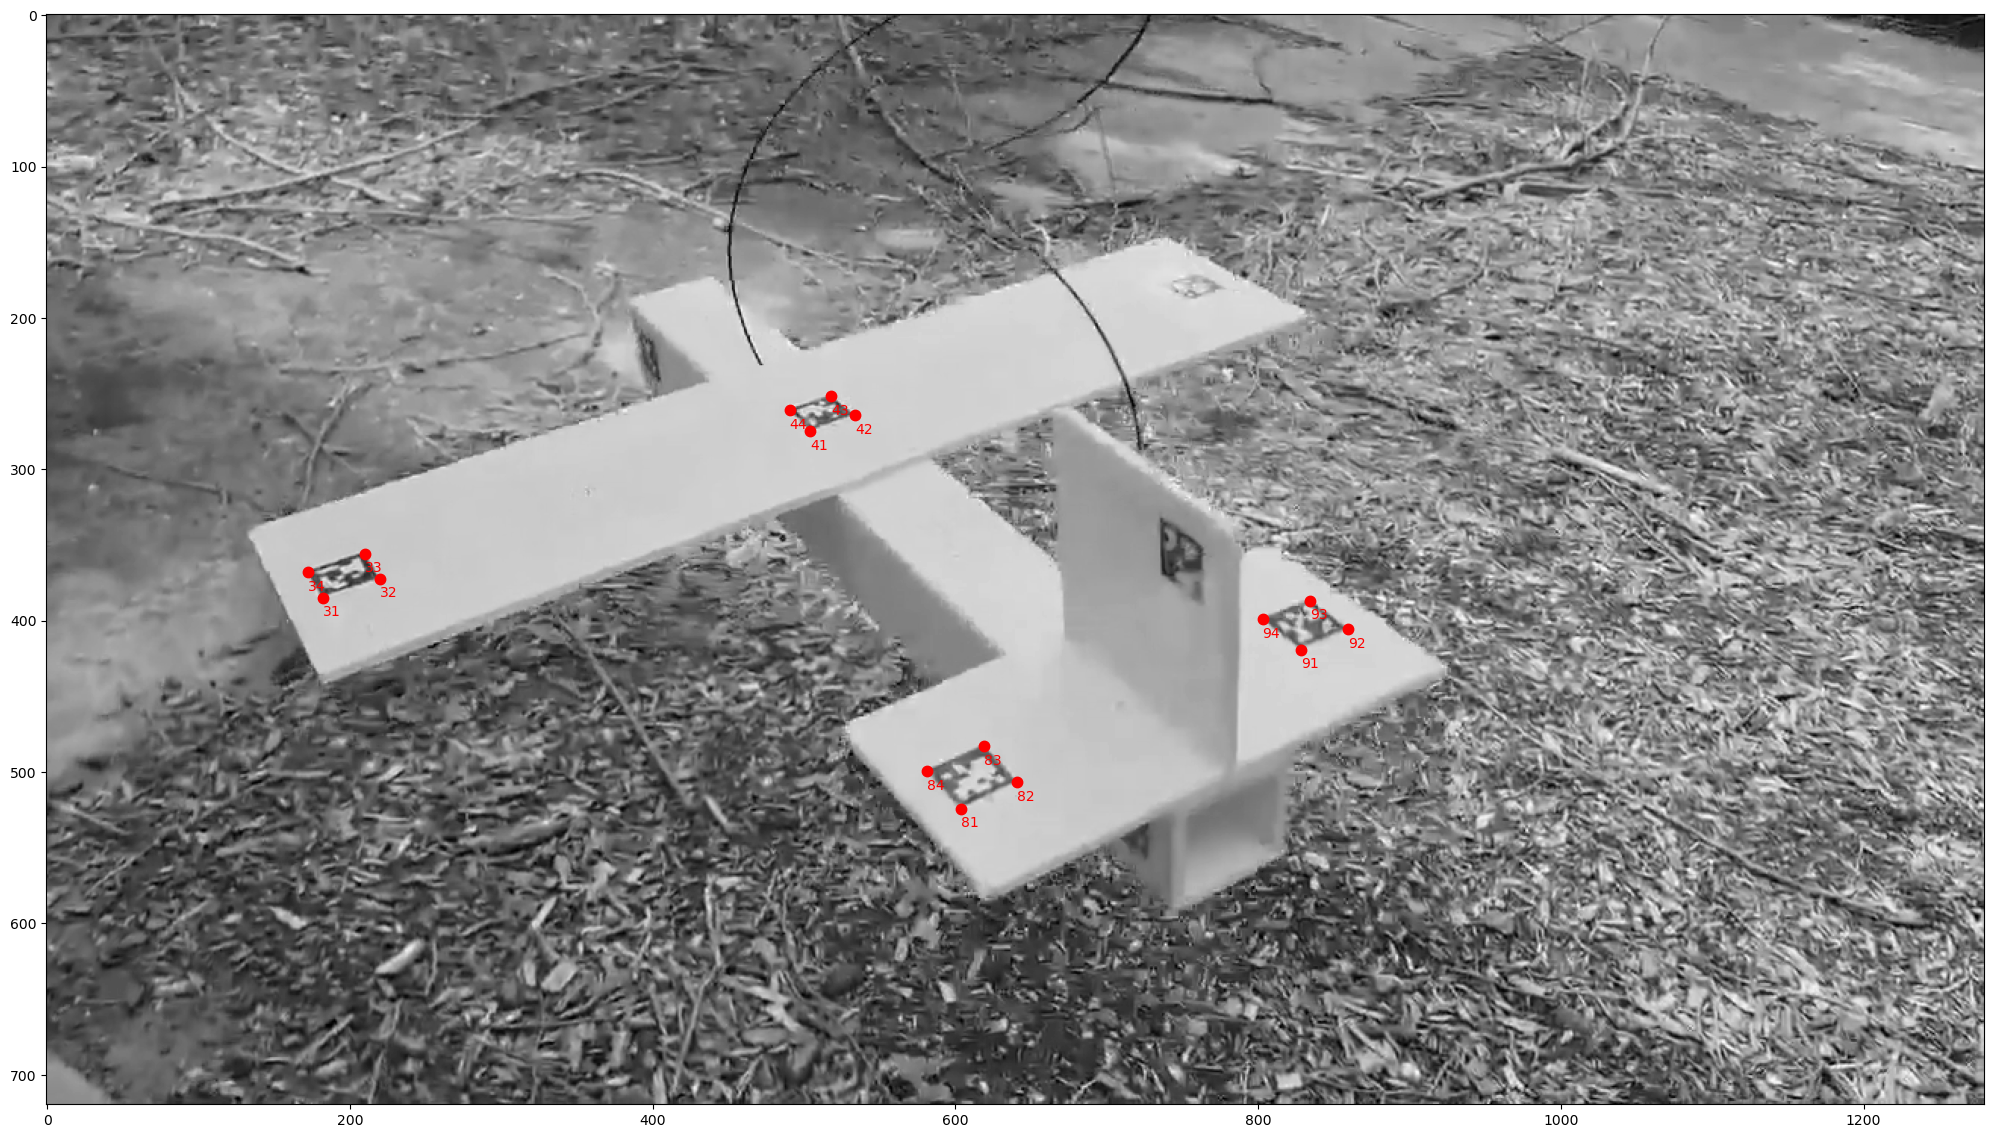

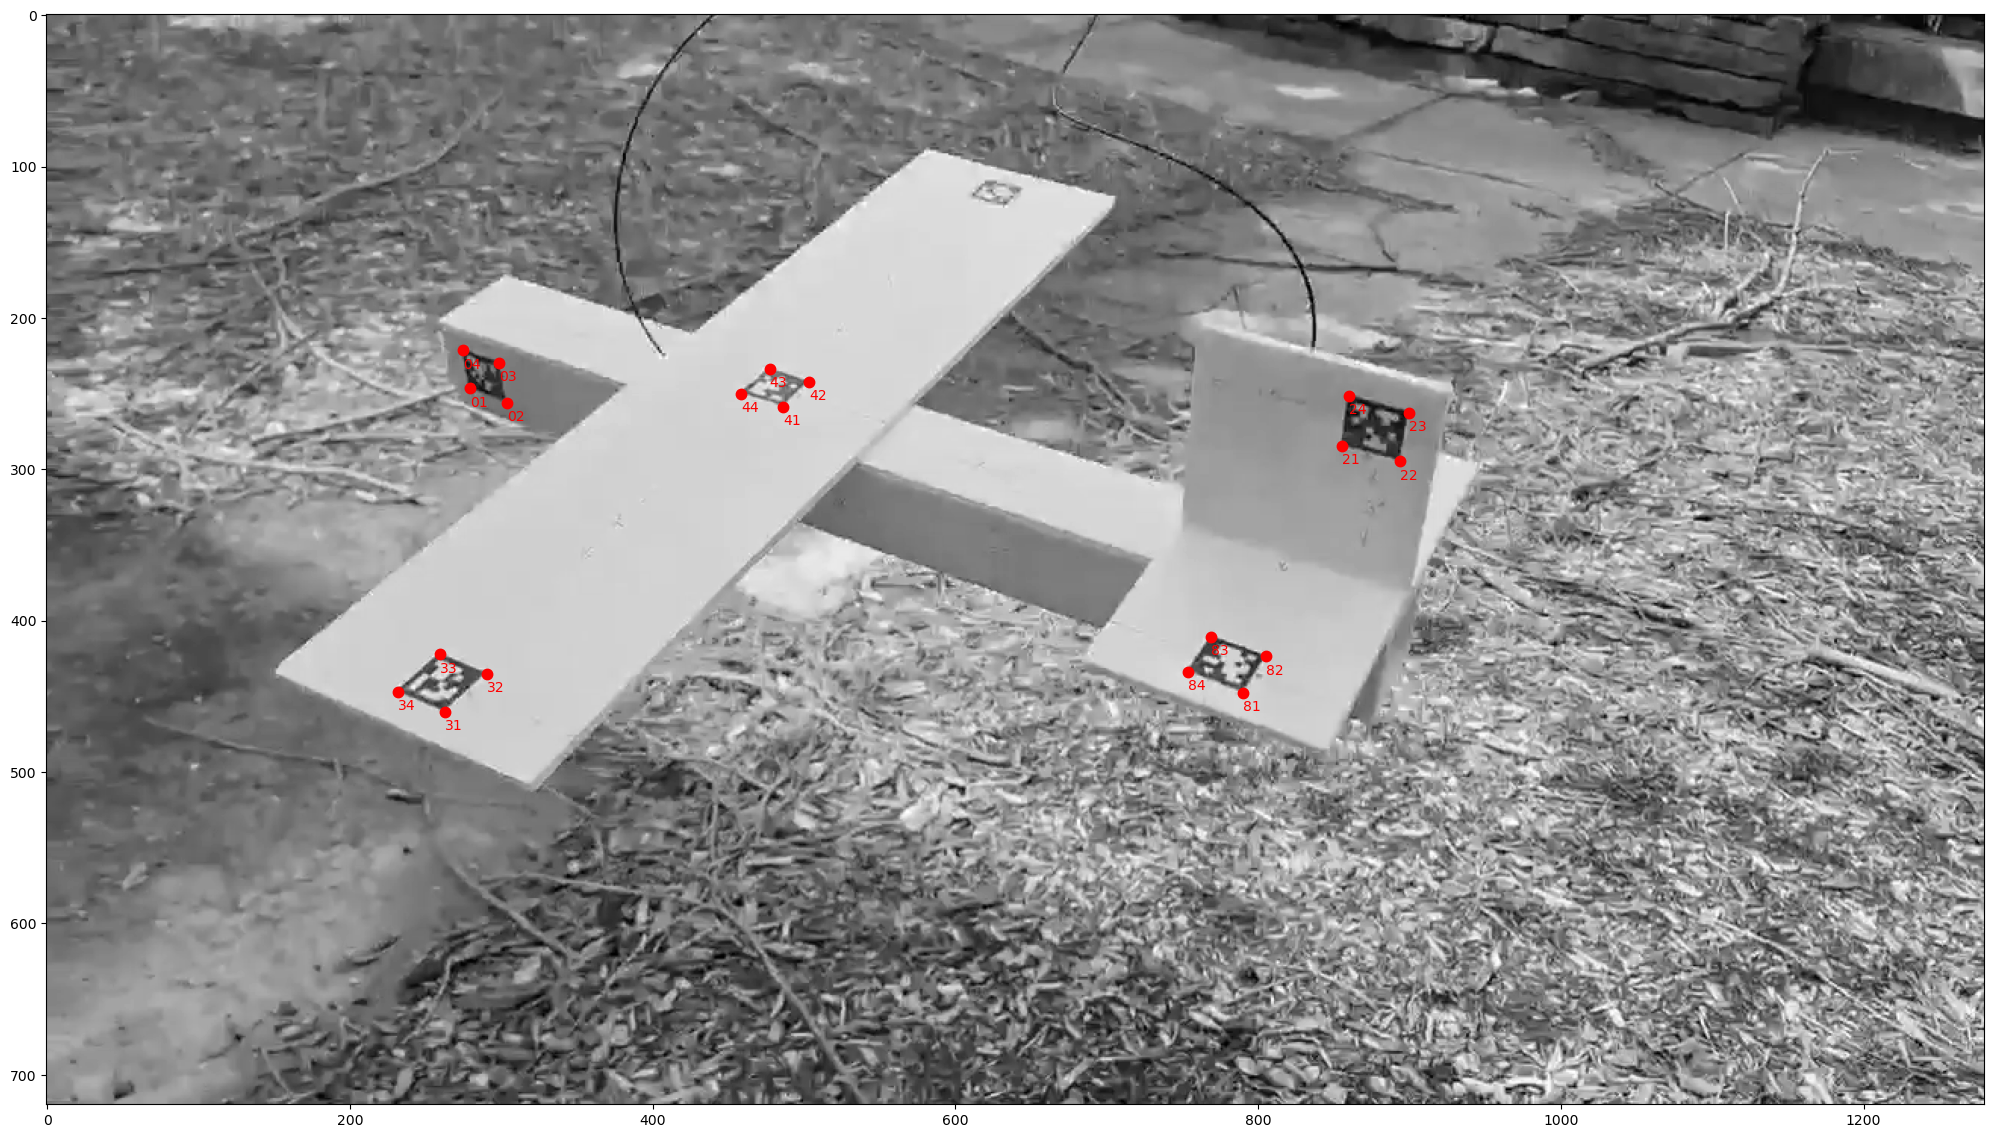

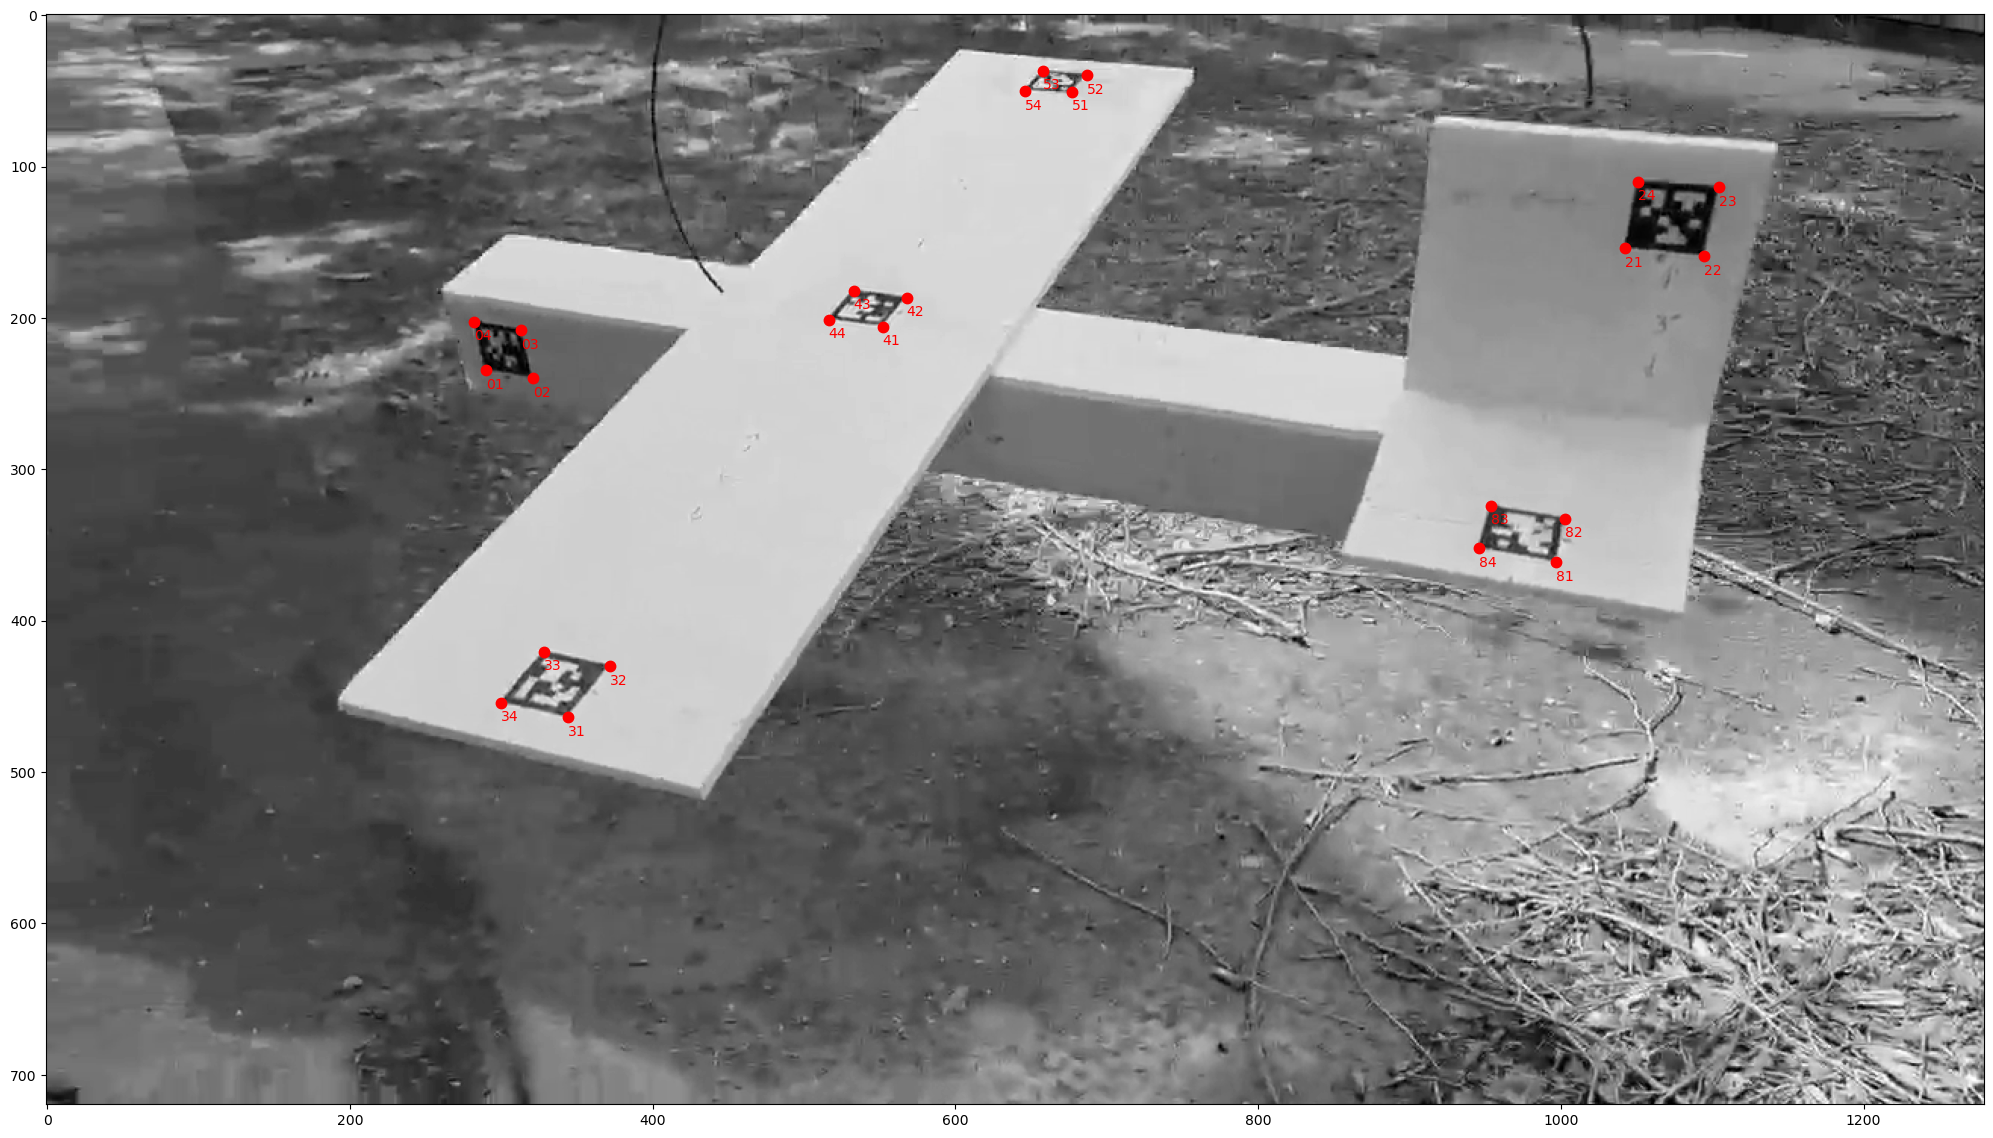

In [50]:
for view in views:  
    img = view['img'] 
    tags = view['tags']
    fig, (ax1) = plt.subplots(1, 1, figsize=(25, 15))
    ax1.imshow(img, cmap='gray')
    for tag in tags:
        ax1.plot(tag["corners"][0][0], tag["corners"][0][1], 'r.', markersize=15) 
        ax1.text(tag["corners"][0][0], tag["corners"][0][1]+12, str(tag["tag_id"]) + "1", color = 'red')
        
        ax1.plot(tag["corners"][1][0], tag["corners"][1][1], 'r.', markersize=15) 
        ax1.text(tag["corners"][1][0], tag["corners"][1][1]+12, str(tag["tag_id"]) + "2", color = 'red')
        
        ax1.plot(tag["corners"][2][0], tag["corners"][2][1], 'r.', markersize=15) 
        ax1.text(tag["corners"][2][0], tag["corners"][2][1]+12, str(tag["tag_id"]) + "3", color = 'red')
        
        ax1.plot(tag["corners"][3][0], tag["corners"][3][1], 'r.', markersize=15) 
        ax1.text(tag["corners"][3][0], tag["corners"][3][1]+12, str(tag["tag_id"]) + "4", color = 'red')
    
    plt.show()

In [16]:
# Create a SIFT feature detector
sift = cv2.SIFT_create()

# create mask
#lower = np.array([65, 71, 72])
#upper = np.array([65, 71, 72])


# Apply detector to find keypoints (pts) and descriptors (desc) in each image
for view in views:    
    pts, desc = sift.detectAndCompute(image=view['hsv_masked'], mask=None)
    view['pts'] = [
        {
            'pt2d': np.array(pt.pt),
            'track': None,
        }
        for pt in pts
    ]
    view['desc'] = desc
    
    #"""  
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
    ax1.imshow(view['img'], cmap='gray')
    ax2.imshow(view['hsv_masked'], cmap='gray')
    plt.show()
    #"""  
    
    #ax1.imshow(view['img'], cmap='gray')
    #ax1.imshow(view['img'], cmap='gray')

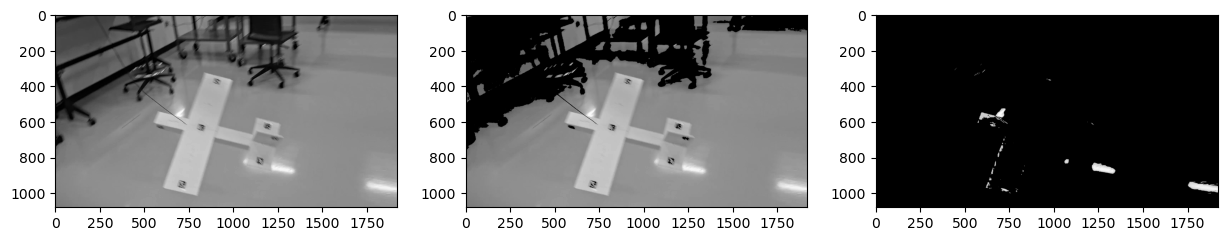

In [23]:
# mask for white areas in image 
#"""
#mask = cv2.inRange(view['img'], 10, 100)
#masked = cv2.bitwise_and(view['img'],view['img'],mask=mask)
#result = view['img'] - masked
view = views[0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
ax1.imshow(view['img'], cmap='gray')
ax2.imshow(view['masked'], cmap='gray')
ax3.imshow(view['hsv_masked'], cmap='gray')
plt.show()
#"""
#view['masked']

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

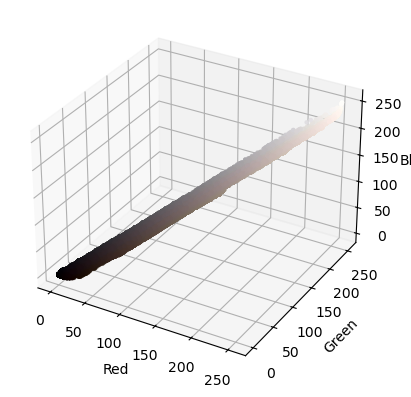

In [25]:
nemo = cv2.cvtColor(view['frame'], cv2.COLOR_BGR2RGB)

r, g, b = cv2.split(nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = nemo.reshape((np.shape(nemo)[0]*np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

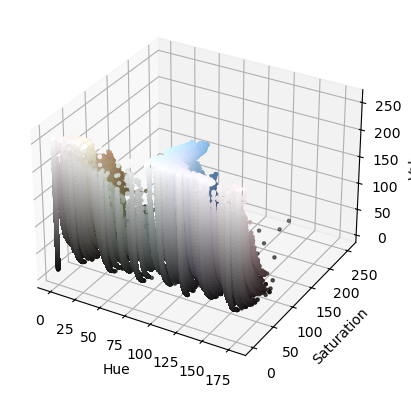

In [277]:
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_nemo)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

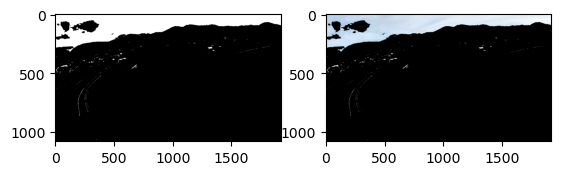

In [278]:
light_orange = (0, 0, 200)
dark_orange = (145, 60, 255)

mask = cv2.inRange(hsv_nemo, light_orange, dark_orange)
result = cv2.bitwise_and(nemo, nemo, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

## Initialize with two-view reconstruction

### Get initial guess

Apply matcher.

In [27]:
matches = sfm.get_good_matches(views[0]['desc'], views[1]['desc'], threshold=matching_threshold)
print(f'found {len(matches)} good matches')

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'knnMatch'
> Overload resolution failed:
>  - queryDescriptors is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'queryDescriptors'
>  - argument for DescriptorMatcher.knnMatch() given by name ('k') and position (2)
>  - argument for DescriptorMatcher.knnMatch() given by name ('k') and position (2)


Store results.

In [15]:
tracks = []
for match in matches:
    track = {
        'p_inA': None,
        'valid': True,
        'matches': [
            {'view_id': 2, 'feature_id': match.queryIdx},
            {'view_id': 3, 'feature_id': match.trainIdx},
        ]
    }
    tracks.append(track)
    views[2]['pts'][match.queryIdx]['track'] = track
    views[3]['pts'][match.trainIdx]['track'] = track

NameError: name 'matches' is not defined

Get image coordinates of matches.

In [324]:
# Create a, b
a = []
b = []
for m in matches:
    a.append(views[2]['pts'][m.queryIdx]['pt2d'])
    b.append(views[3]['pts'][m.trainIdx]['pt2d'])
a = np.array(a)
b = np.array(b)

Visualize all good matches.

IndexError: list index out of range

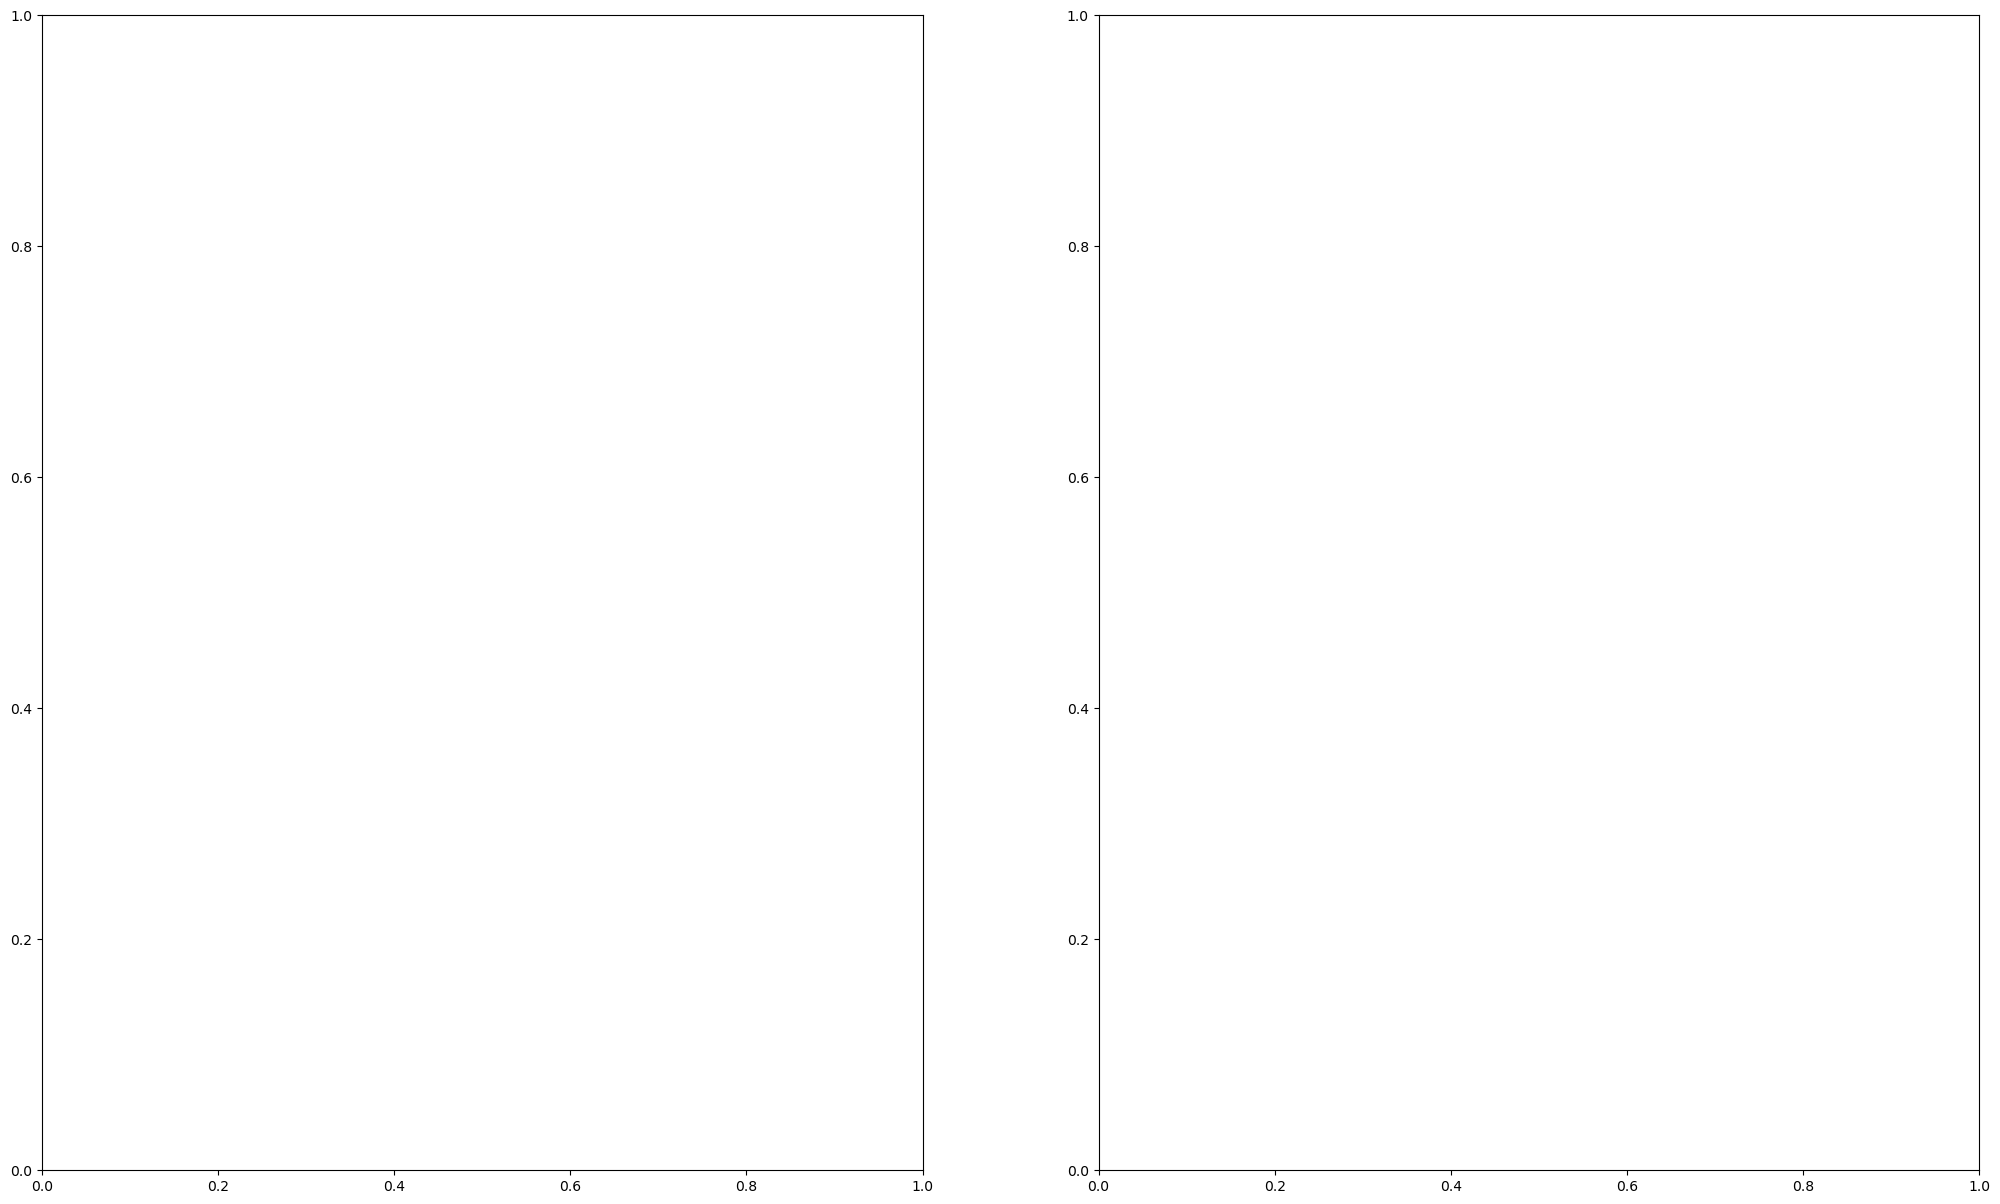

In [14]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))

# Show images
ax1.imshow(views[2]['hsv_masked'], cmap='gray') ## wrong image
ax2.imshow(views[3]['hsv_masked'], cmap='gray') ## wrong image

# Show matches
for a_i, b_i in zip(a, b):
    fig.add_artist(
        ConnectionPatch(
            a_i, b_i, 
            'data', 'data',
            axesA=ax1, axesB=ax2,
            color='red',
            connectionstyle='arc3, rad=0.',
            linewidth=0.5,
        )
    )
    # - Draw red dot at each keypoint
    ax1.plot(a_i[0], a_i[1], 'r.', markersize=2)
    ax2.plot(b_i[0], b_i[1], 'r.', markersize=2)

plt.show()

Do reconstruction.

In [283]:
# Estimate essential matrix
E, num_inliers, mask = sfm.getE(a, b, K, rng, threshold=2e-3, num_iters=1000)
print(f'found {num_inliers} inliers')

# Decompose essential matrix to estimate pose and to triangulate points
R_inB_ofA, p_inB_ofA, p_inA = sfm.decomposeE(a, b, K, E)

found 3 inliers


Store results.

In [284]:
# Store pose estimates
views[0]['R_inB_ofA'] = np.eye(3)
views[0]['p_inB_ofA'] = np.zeros(3)
views[1]['R_inB_ofA'] = R_inB_ofA
views[1]['p_inB_ofA'] = p_inB_ofA

# Always make sure zipped lists are the same length
assert(len(tracks) == len(p_inA))

# Store the position of the point corresponding to each track
for track, p_inA_i in zip(tracks, p_inA):
    track['p_inA'] = p_inA_i

Show results

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[    0.5028    -0.8481    -0.1671     0.2962]
                             [   -0.5176    -0.4503     0.7276    -0.1345]
                             [   -0.6923    -0.2794    -0.6654     0.9456]]

REPROJECTION ERRORS
 Image  0 (    8 points) : (mean, std, max, min) = (492.32, 239.47, 924.20, 223.24)
 Image  1 (    8 points) : (mean, std, max, min) = (1161.32, 876.14, 2859.22, 515.19)


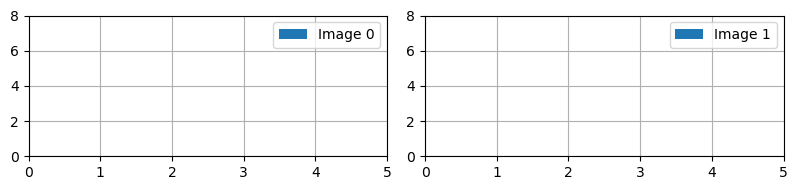

In [285]:
sfm.show_results(views, tracks, K)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_1_ini, tracks_1_ini)
```

In [286]:
views_1_ini, tracks_1_ini = sfm.copy_results(views, tracks)

KeyError: 'desc'

### Optimize

Create initial values, factors, and optimized keys.

In [ ]:
optimizer, initial_values = sfm.get_optimizer(views, tracks, K)

Create and run optimizer.

In [ ]:
result = optimizer.optimize(initial_values)
assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)

Store results from optimization (note that this modifies `views` and `tracks` in place).

In [ ]:
sfm.store_results(views, tracks, K, result, max_reprojection_err=max_reprojection_err)

Show results.

In [ ]:
sfm.show_results(views, tracks, K)

Add visualization of results to the 3D viewer.

In [ ]:
sfm.visualize_results(views, tracks, K, frames_per_second)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_1_opt, tracks_1_opt)
```

In [ ]:
views_1_opt, tracks_1_opt = sfm.copy_results(views, tracks)

## Add a third image

### Get initial guess

Match new images with old images, updating views and tracks.

In [ ]:
iC = sfm.add_next_view(views, tracks, K, matching_threshold=matching_threshold)

Get data for resectioning. Look for tracks that...
* are valid
* have a match with `view_id` that is the same as the new view
* have `p_inA` that is not `None`

Also get data for triangulation. Look for tracks that...
* are valid
* have a match with `view_id` that is the same as the new view
* have `p_inA` that is `None`

In [ ]:
tracks_to_resection = []
tracks_to_triangulate = []
for track in tracks:
    if not track['valid']:
        continue
    
    match = sfm.get_match_with_view_id(track['matches'], iC)
    if match is None:
        continue

    if track['p_inA'] is None:
        tracks_to_triangulate.append(track)
    else:
        tracks_to_resection.append(track)

print(f'{len(tracks_to_resection)} tracks to resection')
print(f'{len(tracks_to_triangulate)} tracks to triangulate')

#### Resection

The output of this process is an estimate of the pose $R^C_A, p^C_A$.

In [ ]:
p_inA = []
c = []
for track in tracks_to_resection:
    assert(track['p_inA'] is not None)
    p_inA.append(track['p_inA'])
    match = sfm.get_match_with_view_id(track['matches'], iC)
    c.append(sfm.get_pt2d_from_match(views, match))
p_inA = np.array(p_inA)
c = np.array(c)

print(f'len(p_inA) = {len(p_inA)}, len(c) = {len(c)}')

Visualize the image coordinates of points on which PnP will be based.

In [ ]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Show image
ax.imshow(views[iC]['img'], cmap='gray')

# Show matches corresponding to points that have already been triangulated
ax.plot(c[:, 0], c[:, 1], 'r.', markersize=4)

# Show plot    
plt.show()

Solve a PnP problem to estimate relative pose.

In [ ]:
R_inC_ofA, p_inC_ofA, num_inliers, mask = sfm.resection(
    p_inA,
    c,
    K,
    rng,
    threshold=2.,
    num_iters=1000,
)
print(f'found {num_inliers} inliers out of {len(mask)}')

Store results.

In [ ]:
views[iC]['R_inB_ofA'] = R_inC_ofA
views[iC]['p_inB_ofA'] = p_inC_ofA

#### Triangulate

Apply function to triangulate all new tracks. Store results.

In [ ]:
for track in tracks_to_triangulate:
    p_inA = sfm.triangulate(track, views, K)
    track['p_inA'] = p_inA

#### Show results

In [ ]:
sfm.show_results(views, tracks, K)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_2_ini, tracks_2_ini)
```

In [ ]:
views_2_ini, tracks_2_ini = sfm.copy_results(views, tracks)

### Optimize

Create initial values, factors, and optimized keys.

In [ ]:
optimizer, initial_values = sfm.get_optimizer(views, tracks, K)

Create and run optimizer.

In [ ]:
result = optimizer.optimize(initial_values)
assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)

Store results from optimization (note that this modifies `views` and `tracks` in place).

In [ ]:
sfm.store_results(views, tracks, K, result, max_reprojection_err=max_reprojection_err)

Show results.

In [ ]:
sfm.show_results(views, tracks, K)

Add visualization of results to the 3D viewer.

In [ ]:
sfm.visualize_results(views, tracks, K, frames_per_second)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_2_opt, tracks_2_opt)
```

In [ ]:
views_2_opt, tracks_2_opt = sfm.copy_results(views, tracks)